In [1]:
from genetic_algorithm import algorithms, selectors, individuals, crossover
from deap import base, creator, tools
import numpy as np
import random

# Definir los parámetros del problema
IND_SIZE = 12  # Número de genes en cada individuo

# Crear los tipos de fitness e individuo en DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", individuals.truss_like, fitness=creator.FitnessMax)

# Configuración del entorno evolutivo utilizando DEAP
toolbox = base.Toolbox()

# Registro de las funciones
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", lambda: creator.Individual(np.array([[random.choice([0, 1]) for _ in range(IND_SIZE)] for _ in range(2)])))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", lambda ind: ind.evaluate())
toolbox.register("clone", lambda ind: ind.clone())
toolbox.register("mutate", lambda ind: ind.mutate())
toolbox.register("mate", crossover.mix_crossover)
toolbox.register("select", selectors.select_individuals_elitist)

n_pop = 50
pop = toolbox.population(n=n_pop)

hall_of_fame = tools.HallOfFame(1)

# Definir estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


population, logbook = algorithms.ea(pop, toolbox, 100, halloffame= hall_of_fame, stats= stats)

pm:0.0: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


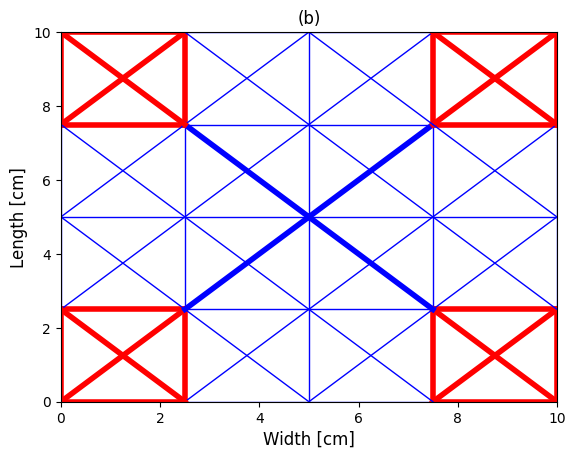

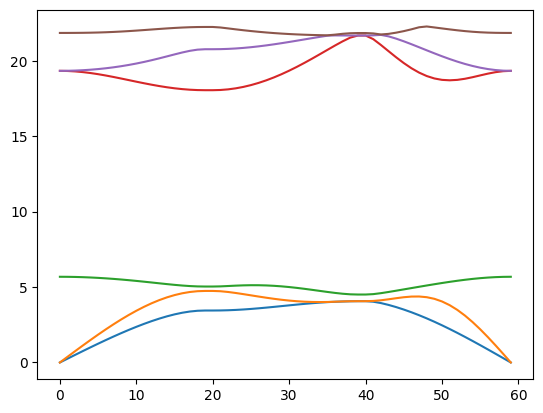

12.36799743463975


In [2]:
best_individual = hall_of_fame[0]
best_individual.plot()
print(best_individual.bandgap)

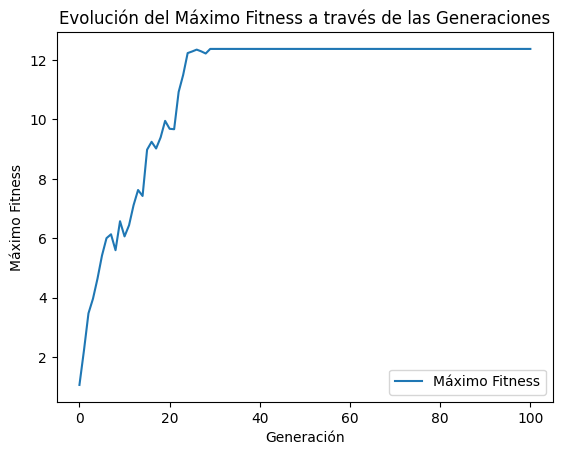

In [3]:
import matplotlib.pyplot as plt
gen, max = logbook.select("gen", "avg")

plt.plot(gen, max, label="Máximo Fitness")
plt.xlabel("Generación")
plt.ylabel("Máximo Fitness")
plt.title("Evolución del Máximo Fitness a través de las Generaciones")
plt.legend()
plt.show()

In [4]:
print(logbook)      

gen	nevals	pm 	avg    	std        	min     	max    
0  	50    	   	1.06693	1.67811    	0.01    	4.0175 
1  	48    	5  	2.22615	1.49541    	0.01    	4.53558
2  	33    	3.2	3.47463	1.16572    	0.341769	4.82772
3  	31    	2.3	3.96649	0.51302    	2.19154 	4.53558
4  	24    	1.4	4.63992	0.547005   	3.79355 	6.39988
5  	32    	1.9	5.41887	0.597996   	4.11476 	6.39988
6  	36    	2.4	6.00272	0.313591   	5.2318  	6.39988
7  	37    	3.8	6.13329	1.24677    	1.98981 	7.60452
8  	40    	6  	5.59818	1.07198    	3.1265  	7.60452
9  	35    	5.1	6.57329	0.670847   	5.28031 	7.51309
10 	44    	7  	6.06246	0.587137   	4.76647 	7.19908
11 	37    	3.3	6.43729	0.814546   	4.65524 	7.61361
12 	41    	4.9	7.11092	0.802933   	5.47954 	8.47197
13 	43    	5.9	7.62291	0.931719   	5.74855 	9.34928
14 	45    	5.6	7.422  	1.16169    	5.35232 	9.34928
15 	38    	3.7	8.97882	0.931952   	7.14858 	10.2164
16 	29    	2.6	9.24367	0.726342   	7.48916 	10.2164
17 	37    	4.3	9.01884	0.916295   	7.2861  	10.2164
18 	32    	3